
# Meteogram

Plots time series data as a meteogram.


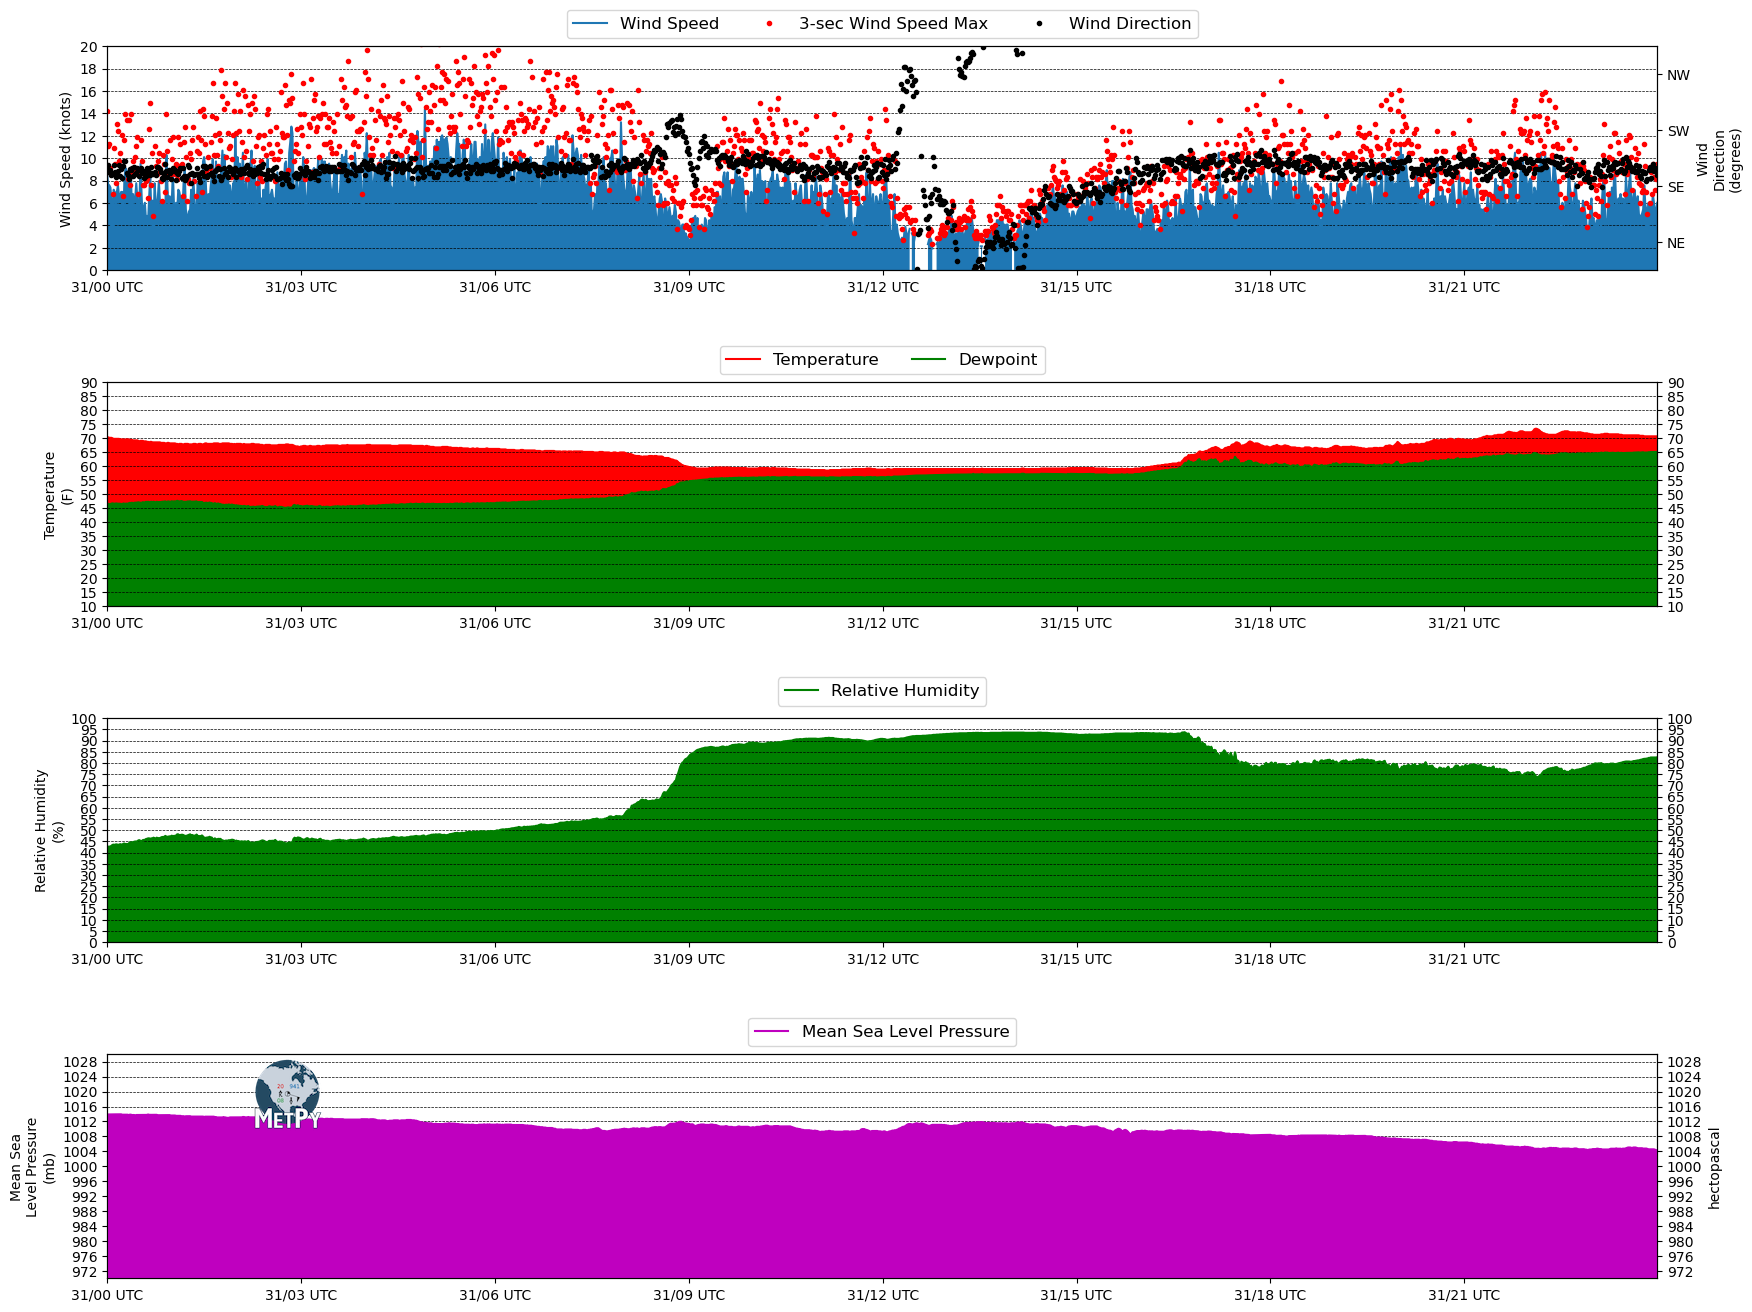

In [1]:
import datetime as dt

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import numpy as np

from metpy.calc import dewpoint_from_relative_humidity
from metpy.cbook import get_test_data
from metpy.plots import add_metpy_logo
from metpy.units import units


def calc_mslp(t, p, h):
    return p * (1 - (0.0065 * h) / (t + 0.0065 * h + 273.15)) ** (-5.257)


# Make meteogram plot
class Meteogram:
    """ Plot a time series of meteorological data from a particular station as a
    meteogram with standard variables to visualize, including thermodynamic,
    kinematic, and pressure. The functions below control the plotting of each
    variable.
    TO DO: Make the subplot creation dynamic so the number of rows is not
    static as it is currently. """

    def __init__(self, fig, dates, probeid, time=None, axis=0):
        """
        Required input:
            fig: figure object
            dates: array of dates corresponding to the data
            probeid: ID of the station
        Optional Input:
            time: Time the data is to be plotted
            axis: number that controls the new axis to be plotted (FOR FUTURE)
        """
        if not time:
            time = dt.datetime.now(dt.timezone.utc)
        self.start = dates[0]
        self.fig = fig
        self.end = dates[-1]
        self.axis_num = 0
        self.dates = mpl.dates.date2num(dates)
        self.time = time.strftime('%Y-%m-%d %H:%M UTC')
        self.title = f'Latest Ob Time: {self.time}\nProbe ID: {probeid}'

    def plot_winds(self, ws, wd, wsmax, plot_range=None):
        """
        Required input:
            ws: Wind speeds (knots)
            wd: Wind direction (degrees)
            wsmax: Wind gust (knots)
        Optional Input:
            plot_range: Data range for making figure (list of (min,max,step))
        """
        # PLOT WIND SPEED AND WIND DIRECTION
        self.ax1 = fig.add_subplot(4, 1, 1)
        ln1 = self.ax1.plot(self.dates, ws, label='Wind Speed')
        self.ax1.fill_between(self.dates, ws, 0)
        self.ax1.set_xlim(self.start, self.end)
        ymin, ymax, ystep = plot_range if plot_range else (0, 20, 2)
        self.ax1.set_ylabel('Wind Speed (knots)', multialignment='center')
        self.ax1.set_ylim(ymin, ymax)
        self.ax1.yaxis.set_major_locator(MultipleLocator(ystep))
        self.ax1.grid(which='major', axis='y', color='k', linestyle='--', linewidth=0.5)
        ln2 = self.ax1.plot(self.dates, wsmax, '.r', label='3-sec Wind Speed Max')

        ax7 = self.ax1.twinx()
        ln3 = ax7.plot(self.dates, wd, '.k', linewidth=0.5, label='Wind Direction')
        ax7.set_ylabel('Wind\nDirection\n(degrees)', multialignment='center')
        ax7.set_ylim(0, 360)
        ax7.set_yticks(np.arange(45, 405, 90))
        ax7.set_yticklabels(['NE', 'SE', 'SW', 'NW'])
        lines = ln1 + ln2 + ln3
        labs = [line.get_label() for line in lines]
        ax7.xaxis.set_major_formatter(mpl.dates.DateFormatter('%d/%H UTC'))
        ax7.legend(lines, labs, loc='upper center',
                   bbox_to_anchor=(0.5, 1.2), ncol=3, prop={'size': 12})

    def plot_thermo(self, t, td, plot_range=None):
        """
        Required input:
            T: Temperature (deg F)
            TD: Dewpoint (deg F)
        Optional Input:
            plot_range: Data range for making figure (list of (min,max,step))
        """
        # PLOT TEMPERATURE AND DEWPOINT
        ymin, ymax, ystep = plot_range if plot_range else (10, 90, 5)
        self.ax2 = fig.add_subplot(4, 1, 2, sharex=self.ax1)
        ln4 = self.ax2.plot(self.dates, t, 'r-', label='Temperature')
        self.ax2.fill_between(self.dates, t, td, color='r')

        self.ax2.set_ylabel('Temperature\n(F)', multialignment='center')
        self.ax2.grid(which='major', axis='y', color='k', linestyle='--', linewidth=0.5)
        self.ax2.set_ylim(ymin, ymax)
        self.ax2.yaxis.set_major_locator(MultipleLocator(ystep))

        ln5 = self.ax2.plot(self.dates, td, 'g-', label='Dewpoint')
        self.ax2.fill_between(self.dates, td, self.ax2.get_ylim()[0], color='g')

        ax_twin = self.ax2.twinx()
        ax_twin.set_ylim(ymin, ymax)
        ax_twin.yaxis.set_major_locator(MultipleLocator(ystep))
        lines = ln4 + ln5
        labs = [line.get_label() for line in lines]
        ax_twin.xaxis.set_major_formatter(mpl.dates.DateFormatter('%d/%H UTC'))

        self.ax2.legend(lines, labs, loc='upper center',
                        bbox_to_anchor=(0.5, 1.2), ncol=2, prop={'size': 12})

    def plot_rh(self, rh, plot_range=None):
        """
        Required input:
            RH: Relative humidity (%)
        Optional Input:
            plot_range: Data range for making figure (list of (min,max,step))
        """
        # PLOT RELATIVE HUMIDITY
        ymin, ymax, ystep = plot_range if plot_range else (0, 100, 5)
        self.ax3 = fig.add_subplot(4, 1, 3, sharex=self.ax1)
        self.ax3.plot(self.dates, rh, 'g-', label='Relative Humidity')
        self.ax3.legend(loc='upper center', bbox_to_anchor=(0.5, 1.22), prop={'size': 12})
        self.ax3.grid(which='major', axis='y', color='k', linestyle='--', linewidth=0.5)
        self.ax3.set_ylim(ymin, ymax)
        self.ax3.yaxis.set_major_locator(MultipleLocator(ystep))

        self.ax3.fill_between(self.dates, rh, self.ax3.get_ylim()[0], color='g')
        self.ax3.set_ylabel('Relative Humidity\n(%)', multialignment='center')
        self.ax3.xaxis.set_major_formatter(mpl.dates.DateFormatter('%d/%H UTC'))
        axtwin = self.ax3.twinx()
        axtwin.set_ylim(ymin, ymax)
        axtwin.yaxis.set_major_locator(MultipleLocator(ystep))

    def plot_pressure(self, p, plot_range=None):
        """
        Required input:
            P: Mean Sea Level Pressure (hPa)
        Optional Input:
            plot_range: Data range for making figure (list of (min,max,step))
        """
        # PLOT PRESSURE
        ymin, ymax, ystep = plot_range if plot_range else (970, 1030, 4)
        self.ax4 = fig.add_subplot(4, 1, 4, sharex=self.ax1)
        self.ax4.plot(self.dates, p, 'm', label='Mean Sea Level Pressure')
        self.ax4.set_ylabel('Mean Sea\nLevel Pressure\n(mb)', multialignment='center')
        self.ax4.set_ylim(ymin, ymax)
        self.ax4.yaxis.set_major_locator(MultipleLocator(ystep))

        axtwin = self.ax4.twinx()
        axtwin.set_ylim(ymin, ymax)
        axtwin.yaxis.set_major_locator(MultipleLocator(ystep))
        axtwin.fill_between(self.dates, p, axtwin.get_ylim()[0], color='m')
        axtwin.xaxis.set_major_formatter(mpl.dates.DateFormatter('%d/%H UTC'))

        self.ax4.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), prop={'size': 12})
        self.ax4.grid(which='major', axis='y', color='k', linestyle='--', linewidth=0.5)
        # OTHER OPTIONAL AXES TO PLOT
        # plot_irradiance
        # plot_precipitation


# set the starttime and endtime for plotting, 24 hour range
endtime = dt.datetime(2016, 3, 31, 22, 0, 0, 0)
starttime = endtime - dt.timedelta(hours=24)

# Height of the station to calculate MSLP
hgt_example = 292.


# Parse dates from .csv file, knowing their format as a string and convert to datetime
def parse_date(date):
    return dt.datetime.strptime(date, '%Y-%m-%d %H:%M:%S')


testdata = np.genfromtxt(get_test_data('timeseries.csv', False), names=True, dtype=None,
                         usecols=list(range(1, 8)),
                         converters={'DATE': parse_date}, delimiter=',')

# Temporary variables for ease
temp = testdata['T']
pressure = testdata['P']
rh = testdata['RH']
ws = testdata['WS']
wsmax = testdata['WSMAX']
wd = testdata['WD']
date = testdata['DATE']

# ID For Plotting on Meteogram
probe_id = '0102A'

data = {'wind_speed': (np.array(ws) * units('m/s')).to(units('knots')),
        'wind_speed_max': (np.array(wsmax) * units('m/s')).to(units('knots')),
        'wind_direction': np.array(wd) * units('degrees'),
        'dewpoint': dewpoint_from_relative_humidity((np.array(temp) * units.degC).to(units.K),
                                                    np.array(rh) / 100.).to(units('degF')),
        'air_temperature': (np.array(temp) * units('degC')).to(units('degF')),
        'mean_slp': calc_mslp(np.array(temp), np.array(pressure), hgt_example) * units('hPa'),
        'relative_humidity': np.array(rh), 'times': np.array(date)}

fig = plt.figure(figsize=(20, 16))
add_metpy_logo(fig, 250, 180)
meteogram = Meteogram(fig, data['times'], probe_id)
meteogram.plot_winds(data['wind_speed'], data['wind_direction'], data['wind_speed_max'])
meteogram.plot_thermo(data['air_temperature'], data['dewpoint'])
meteogram.plot_rh(data['relative_humidity'])
meteogram.plot_pressure(data['mean_slp'])
fig.subplots_adjust(hspace=0.5)
plt.show()